# using pmwd solver and lemur integration

In [1]:
import os

# uncomment to disable NVIDIA GPUs
#os.environ['CUDA_VISIBLE_DEVICES'] = ''
# or pick the device (cpu, gpu, and tpu)
#os.environ['JAX_PLATFORMS'] = 'cpu'

# change JAX GPU memory preallocation fraction
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'

# you do not want this
#os.environ['XLA_FLAGS'] = '--xla_gpu_deterministic_ops=true'

import jax
#jax.print_environment_info()

!nvidia-smi --query-gpu=gpu_name --format=csv,noheader

/usr/lib64/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Tesla V100-PCIE-32GB


In [2]:
# again, this only works on startup!
#from jax import config
#config.update("jax_enable_x64", True)

In [4]:
import jax.numpy as jnp
import logging
import numpy as np
import matplotlib.pyplot as plt
from pmwd import (Configuration, Cosmology, boltzmann, linear_modes,
                  lpt, nbody, scatter)

from lemur import analysis, background, cosmology, limber, plot, utils, constants

In [5]:
L = 1000 #500 #4000 #  # resolution
N = 128 # 128

Lbox = (L, L, 5500)
Nmesh = (N, N, 512)

coord_obs = (L // 2, L // 2, 0)
coord_obsN = (N // 2, N // 2, 0)

a_init = 0.01
a_final = 1.0

chi_grid = (jnp.arange(Nmesh[2]) + 0.5) * Lbox[2] / Nmesh[2]

# tomographic bin means
z_means_analysis = jnp.array([0.5, 1.0, 1.5, 2.0])
zstd = 0.14


def all_los(single_index, delta):
    """
    helper function to map los_indices to slice through
    the delta box (will integrate in codebase soon)
    """

    def index_me(ind): # vmap over Nz
        return delta[tuple(ind)]    

    return jax.vmap(index_me, in_axes=(0,))(single_index)


los_indices = np.load("/data101/makinen/lemur_sims/los_indices_N_%d_Nz_512.npy"%(N))

In [6]:
# let these float for now so we don't have to meshgrid again

#Nx,Ny,Nz = box.Nmesh

def a_to_z(a):
    return (1. / a) - 1.
def z_to_a(z):
    return 1. / (1. + z)

def Jacobian(redshift, omega_m):
    """
    Cosmological Jacobian for tomographic bin calculation
    """
    E = jnp.sqrt(omega_m * (1+redshift)**3 + (1-omega_m))
    return constants.H0 * E / constants.c

def weights_redshift(z, mean=1.0, std=0.14):
    """"
    Calculate weighting at given redshift value
    and mean of tomographic bin
    """
    exponent = - 0.5 * ((z - mean) / std)**2
    norm = std * (2. * np.pi)**0.5
    return jnp.exp(exponent) / norm

def get_weights_in_chi(z, a_grid, 
                       chi_grid,
                       mean=1.0, std=0.14):
    weights_in_z = weights_redshift(z, mean=mean, std=std)     
    weights_in_a = z_to_a(weights_in_z) #jnp.interp(weights_in_z, z, a_grid)

    weights_in_chi = (jnp.exp(
        jnp.interp(
            (jnp.log(weights_in_a)),
            jnp.flip(jnp.log(a_grid)),
            jnp.flip(jnp.log(chi_grid)),
        )
    ))
    
    return weights_in_chi

#@jax.jit
def get_pixel_geometry(Nmesh):
    Nx,Ny,Nz = Nmesh

    # get spherical cap
    x_axis = jnp.arange(0, Nx)
    y_axis = jnp.arange(0, Ny)
    z_axis = jnp.arange(0, Nz)
    xx,yy,zz = jnp.meshgrid(x_axis, y_axis, z_axis, sparse=True)
    xo,yo,zo = coord_obsN
    spherical_cap = (jnp.sqrt(((xx - xo)**2 + (yy-yo)**2 + (zz-zo)**2)) <= Nz)
    
    # get 1/costhheta correction
    costheta = jnp.sqrt((xx - xo)**2 + (yy-yo)**2 + (zz[..., -1]-zo)**2) / Nz
    
    #costheta_1 = jnp.where((costheta == 0), 1.0, 1./costheta)
    costheta_1 = jnp.where(costheta == 0., 
                           1.0, 
                           1./costheta
                          )
    return spherical_cap, costheta_1


# make global
spherical_cap, costheta_1 = get_pixel_geometry(Nmesh)

### pmwd box

In [7]:
import matplotlib.pyplot as plt

from pmwd import (
    Configuration,
    Cosmology, SimpleLCDM,
    boltzmann, linear_power, growth,
    white_noise, linear_modes,
    lpt,
    nbody,
    scatter,
)
from pmwd.pm_util import fftinv
from pmwd.spec_util import powspec
from pmwd.vis_util import simshow

In [210]:
if jax.default_backend() == 'gpu':
    ptcl_spacing = L/N # 1.0  # Lagrangian space Cartesian particle grid spacing, in Mpc/h by default
    ptcl_grid_shape = (256,256,256) #(256,) * 3
else:
    ptcl_spacing = 4.
    ptcl_grid_shape = (64,) * 3

conf2 = Configuration(ptcl_spacing, ptcl_grid_shape, mesh_shape=2)  # 2x mesh shape
print(conf2)

Configuration(ptcl_spacing=10.7421875,
              ptcl_grid_shape=(256, 256, 256),
              mesh_shape=(512, 512, 512),
              cosmo_dtype=dtype('float64'),
              pmid_dtype=dtype('int16'),
              float_dtype=dtype('float32'),
              k_pivot_Mpc=0.05,
              T_cmb=2.7255,
              M=1.98847e+40,
              L=3.0856775815e+22,
              T=3.0856775815e+17,
              transfer_fit=True,
              transfer_fit_nowiggle=False,
              transfer_lgk_min=-4,
              transfer_lgk_max=3,
              transfer_lgk_maxstep=0.0078125,
              growth_rtol=1.4901161193847656e-08,
              growth_atol=1.4901161193847656e-08,
              growth_inistep=(1, None),
              lpt_order=2,
              a_start=0.015625,
              a_stop=1,
              a_lpt_maxstep=0.0078125,
              a_nbody_maxstep=0.015625,
              symp_splits=((0, 0.5), (1, 0.5)),
              chunk_size=16777216)


In [35]:
L / N

3.90625

In [115]:
L=5500
N=512

In [116]:
L/N

10.7421875

In [94]:
# ptcl_spacing = nbody.L/N

In [214]:
512 / 3

170.66666666666666

In [215]:
L

5500

In [211]:
# N = 512
# if jax.default_backend() == 'gpu':
#     ptcl_spacing = L/N # 1.0  # Lagrangian space Cartesian particle grid spacing, in Mpc/h by default
#     ptcl_grid_shape = (N,N,N) #(256,) * 3
# else:
#     ptcl_spacing = 4.
#     ptcl_grid_shape = (64,) * 3

# conf = Configuration(ptcl_spacing, ptcl_grid_shape, mesh_shape=1)  # 2x mesh shape

In [ ]:
N = 512
L = 1000

ptcl_spacing = L/N # 1.0  # Lagrangian space Cartesian particle grid spacing, in Mpc/h by default
ptcl_grid_shape = (N,N,N) #(256,) * 3


conf = Configuration(ptcl_spacing, ptcl_grid_shape, mesh_shape=1)  # 2x mesh shape

In [212]:
print(conf)  # with other default parameters
print(f'Simulating {conf.ptcl_num} particles with a {conf.mesh_shape} mesh for {conf.a_nbody_num} time steps.')

Configuration(ptcl_spacing=10.7421875,
              ptcl_grid_shape=(512, 512, 512),
              mesh_shape=(1536, 1536, 1536),
              cosmo_dtype=dtype('float64'),
              pmid_dtype=dtype('int16'),
              float_dtype=dtype('float32'),
              k_pivot_Mpc=0.05,
              T_cmb=2.7255,
              M=1.98847e+40,
              L=3.0856775815e+22,
              T=3.0856775815e+17,
              transfer_fit=True,
              transfer_fit_nowiggle=False,
              transfer_lgk_min=-4,
              transfer_lgk_max=3,
              transfer_lgk_maxstep=0.0078125,
              growth_rtol=1.4901161193847656e-08,
              growth_atol=1.4901161193847656e-08,
              growth_inistep=(1, None),
              lpt_order=2,
              a_start=0.015625,
              a_stop=1,
              a_lpt_maxstep=0.0078125,
              a_nbody_maxstep=0.015625,
              symp_splits=((0, 0.5), (1, 0.5)),
              chunk_size=16777216)
Simulat

In [165]:
cosmo = Cosmology.from_sigma8(
        conf, sigma8=0.811, Omega_m=0.3, Omega_b=0.05, h=0.7, n_s=0.96)
#Cosmology(conf, A_s_1e9=2.0, n_s=0.96, Omega_m=0.3, Omega_b=0.05, h=0.7)
# or simply use the predefined SimpleLCDM
#cosmo = SimpleLCDM(conf)

print(cosmo)

Cosmology(A_s_1e9=Array(1.995, dtype=float64),
          n_s=Array(0.96, dtype=float64),
          Omega_m=Array(0.3, dtype=float64),
          Omega_b=Array(0.05, dtype=float64),
          h=Array(0.7, dtype=float64),
          Omega_k_=None,
          w_0_=None,
          w_a_=None,
          transfer=None,
          growth=None,
          varlin=None)


In [166]:
%time cosmo = jax.block_until_ready(boltzmann(cosmo, conf))
%timeit jax.block_until_ready(boltzmann(cosmo, conf))

CPU times: user 27 ms, sys: 6.26 ms, total: 33.2 ms
Wall time: 22.6 ms
15.1 ms ± 267 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [167]:
seed = 0
modes = white_noise(seed, conf)

modes = linear_modes(modes, cosmo, conf)

In [168]:
%time ptcl, obsvbl = jax.block_until_ready(lpt(modes, cosmo, conf))
%timeit jax.block_until_ready(lpt(modes, cosmo, conf))
ptcl.disp.std(), ptcl.vel.std()

CPU times: user 968 ms, sys: 51.7 ms, total: 1.02 s
Wall time: 1 s
206 ms ± 72.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


(Array(0.113, dtype=float32), Array(0.008, dtype=float32))

In [169]:
%time jax.block_until_ready(nbody(ptcl, obsvbl, cosmo, conf))
%time ptcl, obsvbl = jax.block_until_ready(nbody(ptcl, obsvbl, cosmo, conf))
ptcl.disp.std(), ptcl.vel.std()

CPU times: user 14.5 s, sys: 9.93 s, total: 24.4 s
Wall time: 25.6 s
CPU times: user 11.5 s, sys: 9.85 s, total: 21.3 s
Wall time: 23.5 s


(Array(4.75, dtype=float32), Array(2.36, dtype=float32))

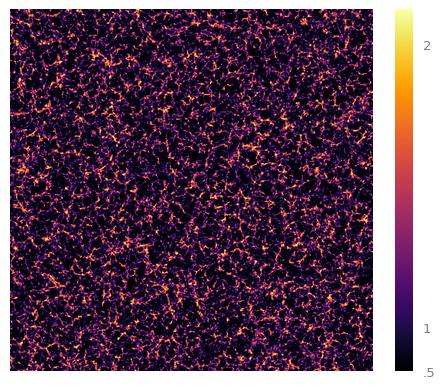

In [170]:
dens = scatter(ptcl, conf)
simshow(dens[:16].mean(axis=0), norm='CosmicWebNorm');

In [200]:
conf.cell_size, conf.ptcl_grid_shape, conf.ptcl_spacing

(10.7421875, (512, 512, 512), 10.7421875)

In [202]:
conf

Configuration(ptcl_spacing=10.7421875, ptcl_grid_shape=(512, 512, 512), mesh_shape=(512, 512, 512), cosmo_dtype=dtype('float64'), pmid_dtype=dtype('int16'), float_dtype=dtype('float32'), k_pivot_Mpc=0.05, T_cmb=2.7255, M=1.98847e+40, L=3.0856775815e+22, T=3.0856775815e+17, transfer_fit=True, transfer_fit_nowiggle=False, transfer_lgk_min=-4, transfer_lgk_max=3, transfer_lgk_maxstep=0.0078125, growth_rtol=1.4901161193847656e-08, growth_atol=1.4901161193847656e-08, growth_inistep=(1, None), lpt_order=2, a_start=0.015625, a_stop=1, a_lpt_maxstep=0.0078125, a_nbody_maxstep=0.015625, symp_splits=((0, 0.5), (1, 0.5)), chunk_size=16777216)

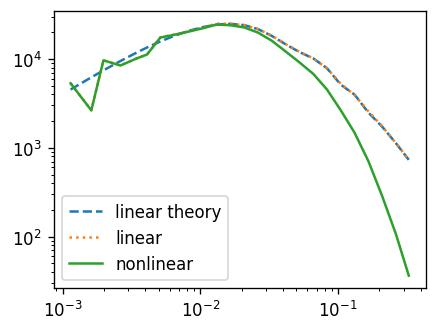

In [172]:
k, P, _, _ = powspec(dens, conf.cell_size)

dens_lin = fftinv(modes, shape=conf.ptcl_grid_shape, norm=conf.ptcl_spacing)
dens_lin *= growth(conf.a_stop, cosmo, conf)
k_lin, P_lin, _, _ = powspec(dens_lin, conf.ptcl_spacing)

P_linth = linear_power(k, conf.a_stop, cosmo, conf)

plt.figure(figsize=(4, 3), dpi=120)
plt.loglog(k, P_linth, ls='--', label='linear theory')
plt.loglog(k_lin, P_lin, ls=':', label='linear')
plt.loglog(k, P, ls='-', label='nonlinear')
plt.legend();

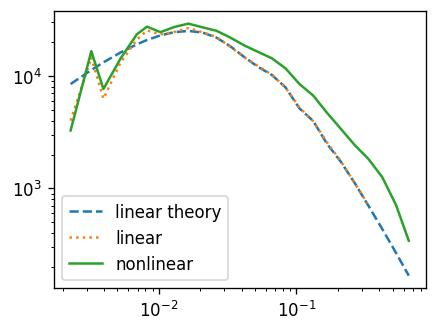

In [127]:
k, P, _, _ = powspec(dens, conf.cell_size)

dens_lin = fftinv(modes, shape=conf.ptcl_grid_shape, norm=conf.ptcl_spacing)
dens_lin *= growth(conf.a_stop, cosmo, conf)
k_lin, P_lin, _, _ = powspec(dens_lin, conf.ptcl_spacing)

P_linth = linear_power(k, conf.a_stop, cosmo, conf)

plt.figure(figsize=(4, 3), dpi=120)
plt.loglog(k, P_linth, ls='--', label='linear theory')
plt.loglog(k_lin, P_lin, ls=':', label='linear')
plt.loglog(k, P, ls='-', label='nonlinear')
plt.legend();

In [173]:
dens.shape

(512, 512, 512)

In [174]:
z_means_analysis, N

(Array([0.5, 1. , 1.5, 2. ], dtype=float64), 512)

In [130]:
los_indices = np.load("/data101/makinen/lemur_sims/los_indices_N_%d_Nz_512.npy"%(N))

In [175]:
delta = dens - dens.mean()

In [176]:
Nx,Ny,Nz = delta.shape

In [188]:
Nmesh = delta.shape
spherical_cap, costheta_1 = get_pixel_geometry(Nmesh)

spherical_cap = jnp.ones(spherical_cap.shape)

In [189]:
spherical_cap.shape

(512, 512, 512)

In [179]:
ptcl_spacing # L / N

10.7421875

In [180]:
Lbox = tuple(np.array(Nmesh) * ptcl_spacing)
Lbox

(5500.0, 5500.0, 5500.0)

In [181]:
    #los_indices = np.load("/data101/makinen/lemur_sims/los_indices_N_%d_Nz_512.npy"%(N))
sigma8 = 0.811
omegam = 0.3


_all_los = lambda i: all_los(i, delta=delta)
delta_los = jax.vmap(_all_los)(los_indices).reshape(Nx,Ny,Nz)

# now do convergence nonsense

cosmo_lemur = cosmology.CosmologicalParameters(sigma8=sigma8, Omega_m=omegam)

# the corresponding scale factor grid changes with cosmology
# simulation box physical terms (comoving grid)
chi_grid = (jnp.arange(Nmesh[2]) + 0.5) * Lbox[2] / Nmesh[2]
omega_m = cosmo_lemur.Omega_m
a_grid = background.compute_scale_factor_at_comoving_distance(chi_grid, cosmo_lemur)
z_grid = a_to_z(a_grid)

lensing_factor = 1.5 * omega_m * constants.H0**2 / constants.c**2
chi_source = chi_grid[-1]
kernel = utils.calculate_lensing_efficiency(chi_grid, chi_source) / a_grid

# kernel becomes r / costheta; integrate only up to spherical cap rmax
#spherical_cap = simulator_args["spherical_cap"]
#costheta_1 = simulator_args["costheta_1"] #= get_pixel_geometry(box.Nmesh)


#@partial(jax.jit, static_argnums=(1,2))





#kappa_tomo = jnp.squeeze(jax.vmap(get_tomobin)(zmeans))

In [190]:
def get_tomobin(zmean, zstd=zstd, delta_los=delta_los):
    
    ws = get_weights_in_chi(z_grid, 
                            a_grid,
                            chi_grid,
                            zmean, 
                            std=zstd
                           ) 
    
    def fn(k_ij, weights=ws):
        """
        k_ij: 3D field slice k[i,j,:]
        weights: (Nz,) weight array
        """
        return jnp.sum(k_ij * ws * kernel * Jacobian(z_grid, cosmo.Omega_m)) 
    
    kappa_tomo = jax.vmap(jax.vmap(fn, in_axes=(0,)), in_axes=(1,))(delta_los * spherical_cap * costheta_1)
    kappa_tomo -= jnp.mean(kappa_tomo)

    return kappa_tomo * lensing_factor

In [191]:
kappa_tomo = jnp.squeeze(jax.vmap(get_tomobin)(z_means_analysis))

In [192]:
kappa_tomo.shape

(4, 512, 512)

In [193]:
kappa_extr = kappa_tomo[0].max()

In [196]:
kappa_extr

Array(0.007, dtype=float64)

/tmp/ipykernel_62485/654024235.py:28: MatplotlibDeprecationWarning: The toggle_label function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use ax.tick_params and colorbar.set_label instead.
  ax.cax.toggle_label(True)


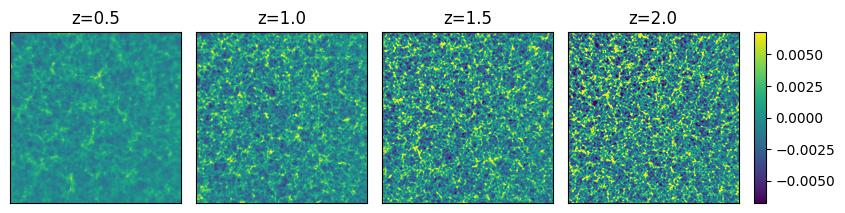

In [197]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# Set up figure and image grid
fig = plt.figure(figsize=(9.75, 3))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,4),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

for i,z in enumerate(z_means_analysis):

    ax = grid[i]
    im = ax.imshow(kappa_tomo[i], vmin=-kappa_extr, vmax=kappa_extr, interpolation='spline36')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("z=%.1f"%(z))
    
# Colorbar
ax.cax.colorbar(im)
ax.cax.toggle_label(True)

#plt.tight_layout()    # Works, but may still require rect paramater to keep colorbar labels visible
plt.show()